In [ ]:
# Geschwindigkeitshistogramme: Vergleich zwischen Richter et al. (2014) mit DB Rad+ Daten auf Radverkehrsinfrastruktur (Nach WFS Radverkehrsinfrastruktur des SenUVK - veraltet!)
# Zur Erstellung des Codes wurde die generative Künstliche Intelligenz (KI) „Claude AI“ des Anbieters Anthropic in Version 3.7 genutzt

Reading the parquet file...
Filtered to 140632 segments with valid rva_typ values
Analyzing period: 2304-2412

Sample histogram format:
[3, 1, 0, 1, 2, 0, 2, 2, 1, 1, 5, 17, 9, 26, 17, 36, 50, 45, 37, 42, 41, 44, 23, 23, 13, 11, 12, 6, 7, 4, 1, 4]
Type: <class 'str'>

Processing histograms...
Calculating weighted histograms...
Successfully processed 140632 segments with valid histograms


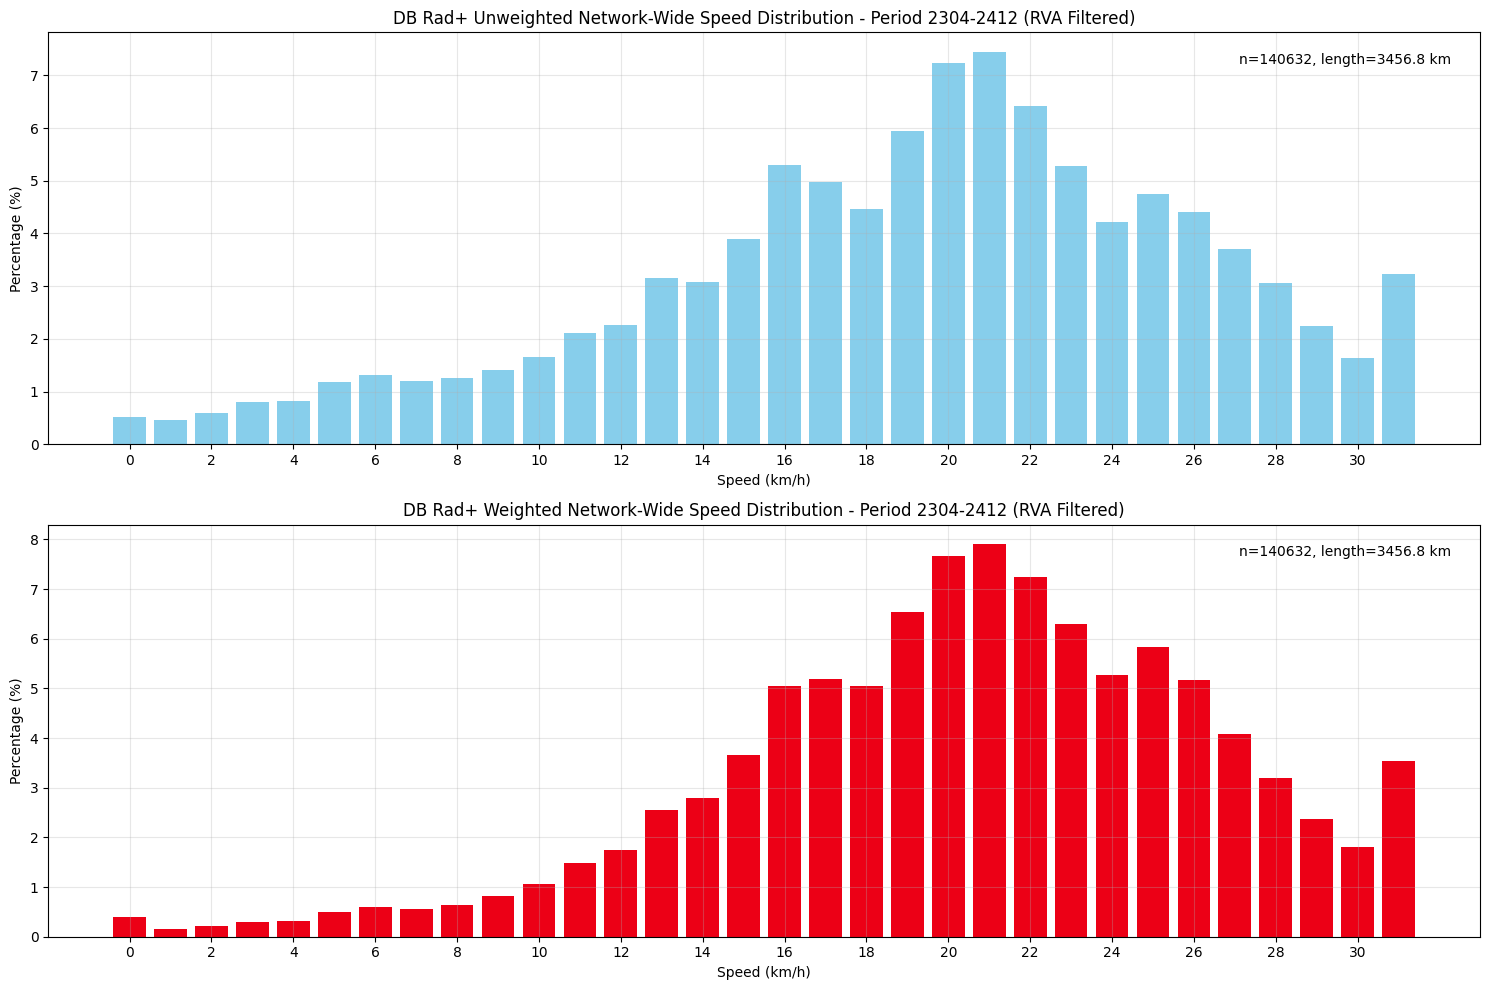

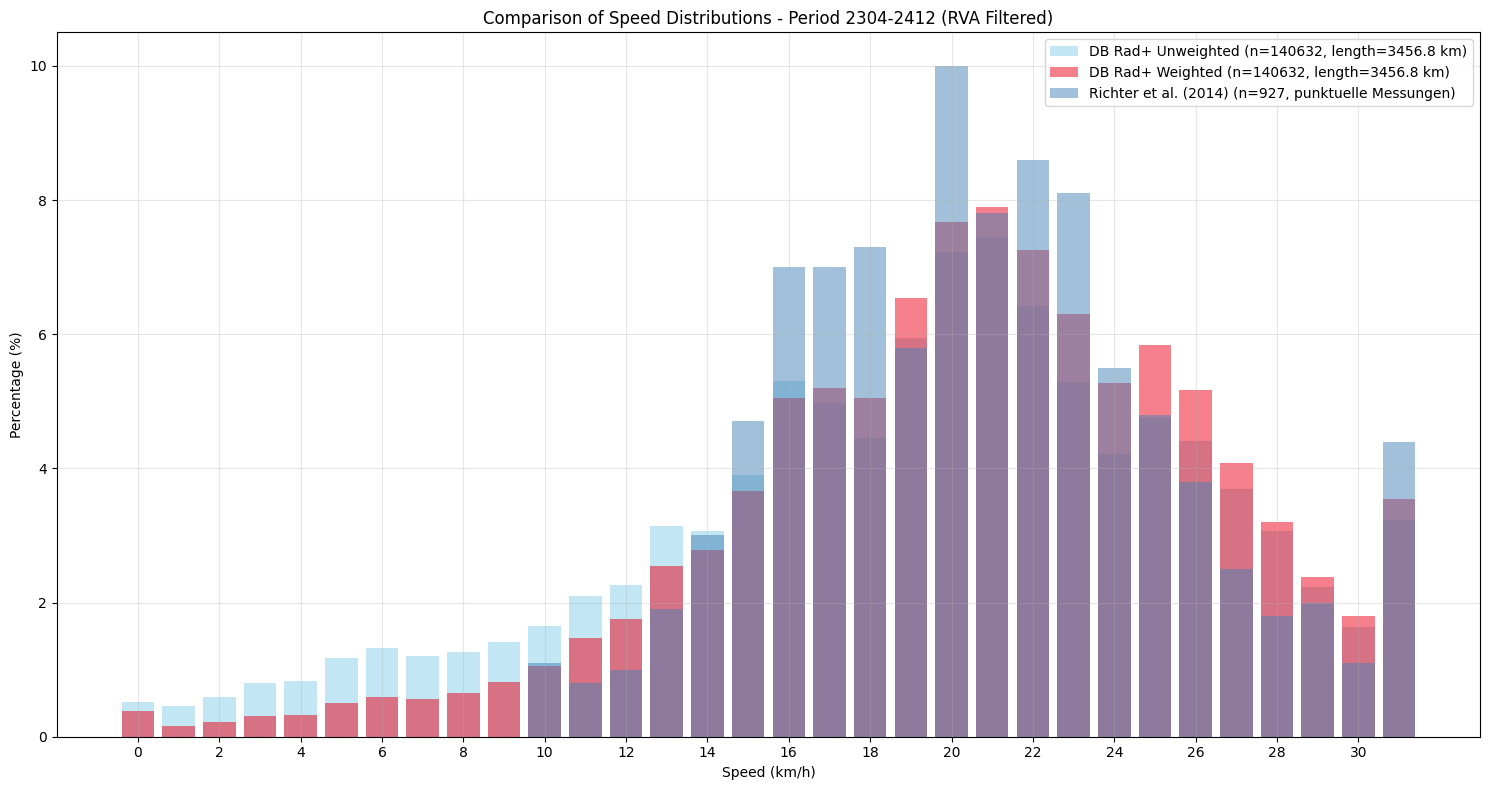

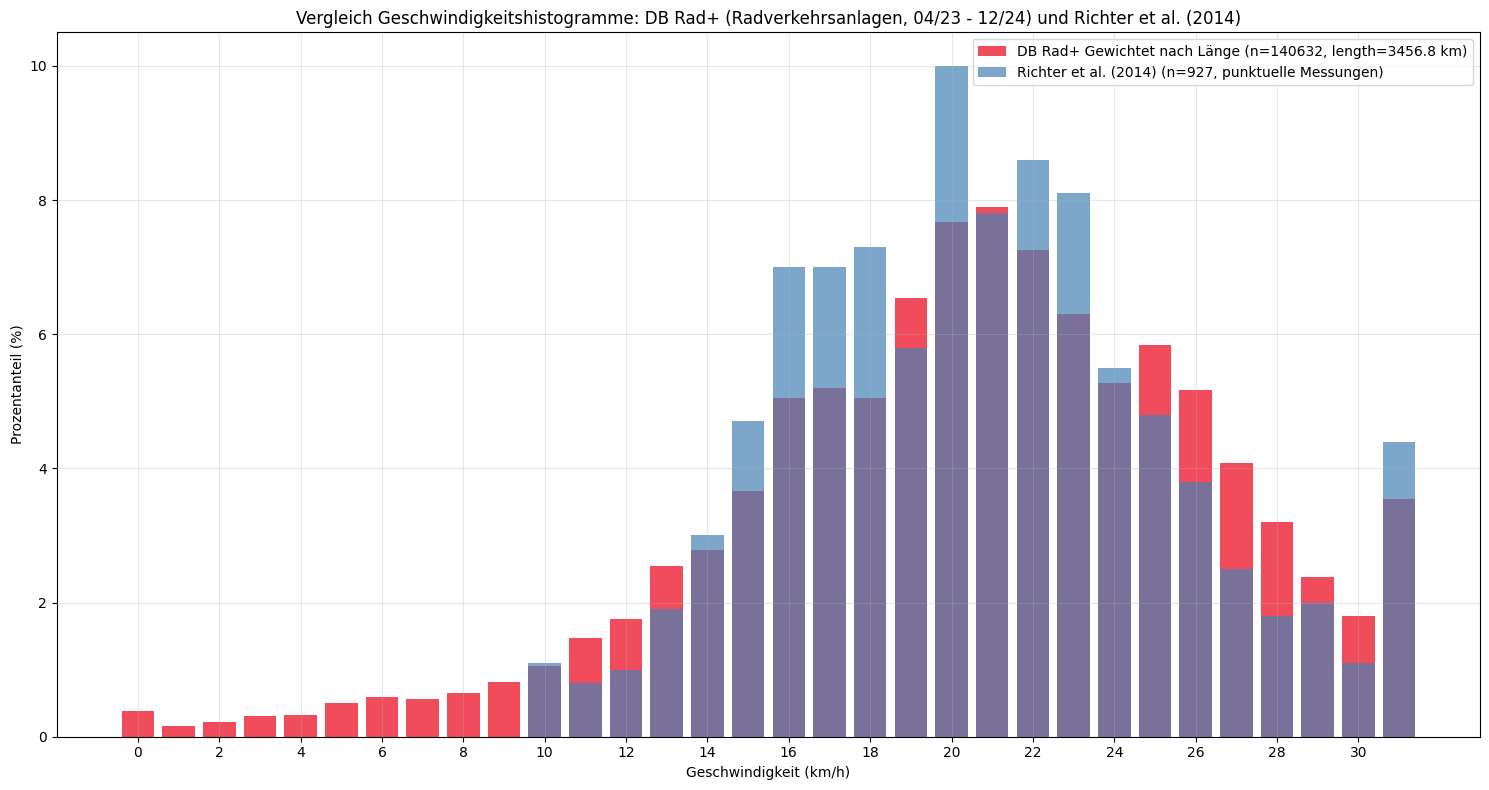

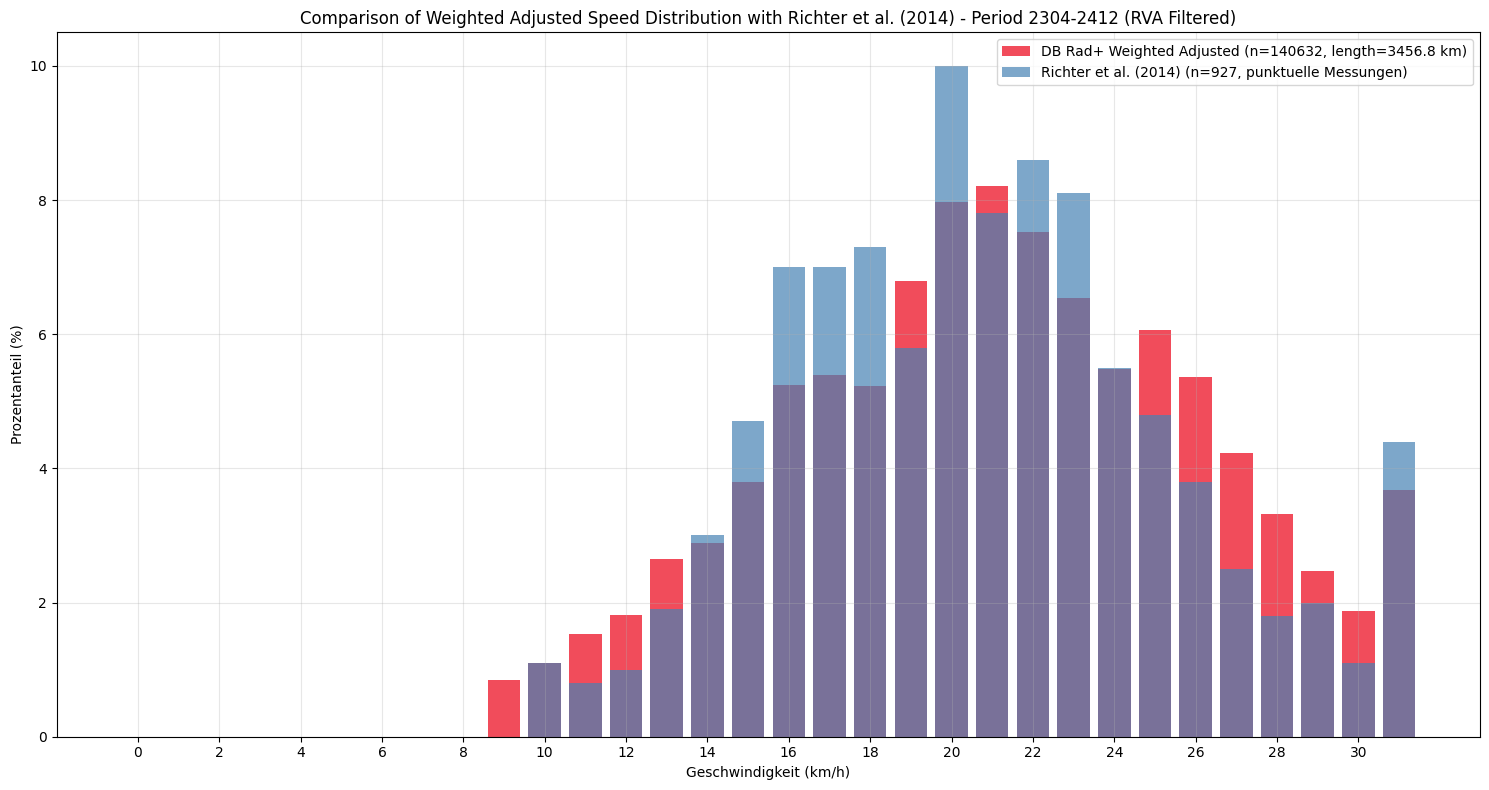

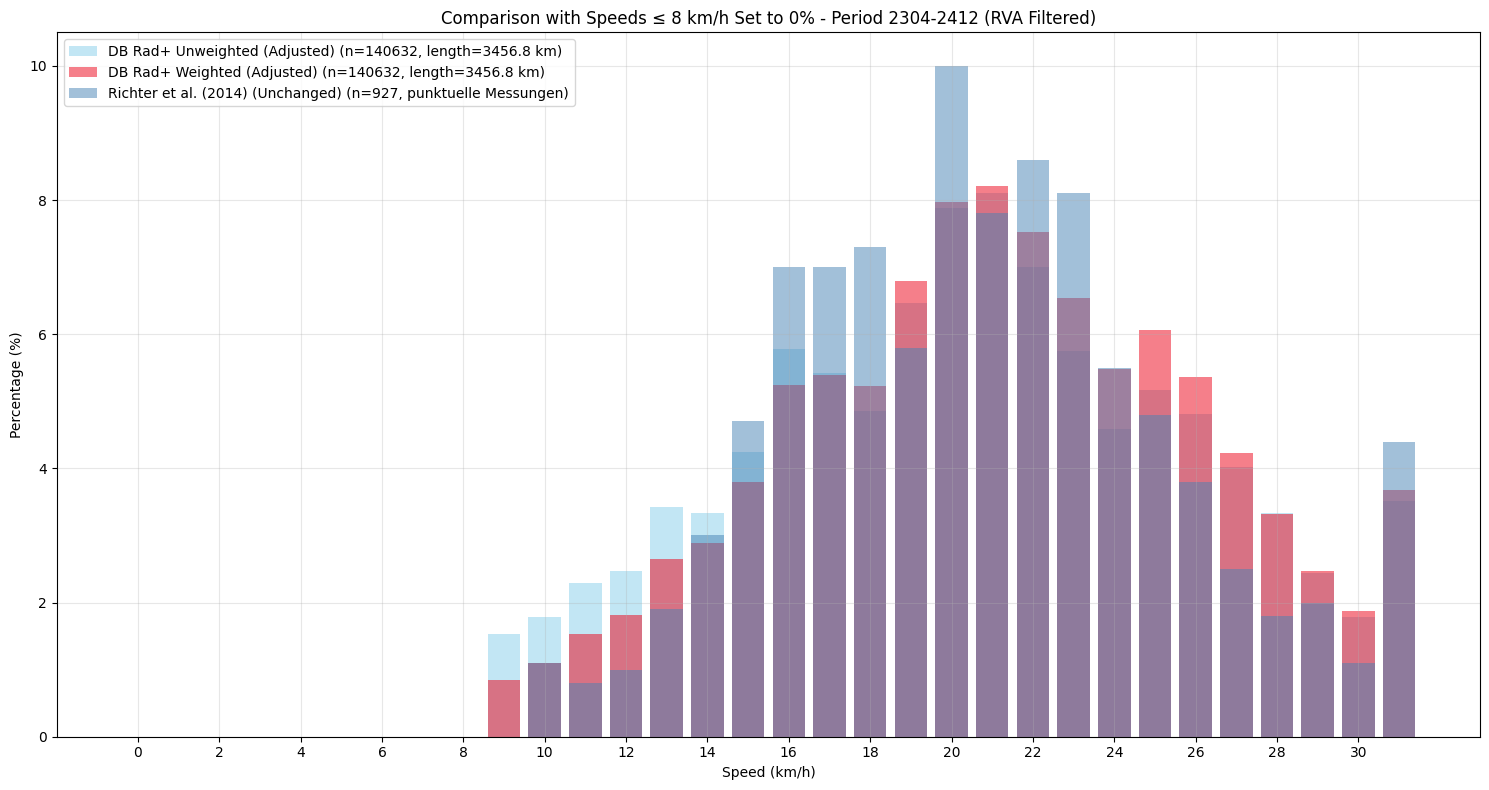


Statistics for Period 2304-2412 (RVA Filtered):
                    DB Rad+ Unweighted    DB Rad+ Weighted    Richter et al. (2014)
                    (n=140632, length=3456.8 km)    (n=140632, length=3456.8 km)    (n=927, punktuelle Messungen)
-----------------------------------------------------------------
Mean Speed (km/h):   19.2           20.5             20.8
Median (km/h):       20             21               20
85th Percentile:     26             26               25

Adjusted Statistics for Period 2304-2412 (RVA Filtered) (Speeds ≤ 8 km/h Set to 0% for Your Data Only):
                    DB Rad+ Unweighted    DB Rad+ Weighted    Richter et al. (2014)
                    (Adjusted)    (Adjusted)         (Unchanged)
                    (n=140632, length=3456.8 km)    (n=140632, length=3456.8 km)    (n=927, punktuelle Messungen)
-----------------------------------------------------------------
Mean Speed (km/h):   20.5           21.1             20.8
Median (km/h):       21  

In [6]:
# Geschwindigkeitshistogramme: Vergleich zwischen Richter et al. (2014) mit DB Rad+ Daten auf Radverkehrsinfrastruktur (Nach WFS Radverkehrsinfrastruktur des SenUVK - veraltet!)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Create directory for results if it doesn't exist
os.makedirs("analysis_results/004_Richter_Geschwindigkeit", exist_ok=True)

# Define plot labels and titles (centralized for easy adjusting)
data_label = "DB Rad+"
richter_label = "Richter et al. (2014)"
time_period_label = None  # Will be set after reading data
richter_sample_size = "n=927, punktuelle Messungen"
# DB brand color red
db_red = '#EC0016'  # Adjust if needed to match DB's exact red
richter_color = '#4682B4'  # Steel blue, distinguishable from DB red

# Load the data (only columns we need)
print("Reading the parquet file...")
columns_to_read = ['id', 'length_m_RVA_clip', '2304-2412_speeds', 'rva_typ']
df = pd.read_parquet("data/network_all_months_plus_25833_RVA_clipped.parquet", columns=columns_to_read)

# Filter to include only features with a value in the rva_typ field
df = df[df['rva_typ'].notna()]
print(f"Filtered to {len(df)} segments with valid rva_typ values")

# Extract the time period from the histogram field name
hist_field = '2304-2412_speeds'
time_period = hist_field.split('_')[0]  # Extract '2304-2412' part
time_period_label = f"Period {time_period} (RVA Filtered)"
print(f"Analyzing period: {time_period}")

# Calculate total length for labeling
total_length_km = df['length_m_RVA_clip'].sum() / 1000
db_sample_size = f"n={len(df)}, length={total_length_km:.1f} km"

# Check the format of the speed histogram
sample_hist = df.loc[df[hist_field].notna()].iloc[0][hist_field]
print("\nSample histogram format:")
print(sample_hist)
print(f"Type: {type(sample_hist)}")

# Function to process histograms and handle different formats
def process_histogram(hist):
    # Skip if histogram is missing
    if pd.isna(hist):
        return None
    
    # Convert to list if it's not already
    if isinstance(hist, str):
        try:
            hist = eval(hist)  # Convert string representation to list
        except:
            return None
    
    # Ensure hist is a list or array we can work with
    if not isinstance(hist, (list, np.ndarray)):
        return None
    
    return hist

# Process histograms
print("\nProcessing histograms...")
df['processed_hist'] = df[hist_field].apply(process_histogram)

# Calculate weighted histograms using length_m_RVA_clip
print("Calculating weighted histograms...")
df['weighted_hist'] = df.apply(
    lambda row: [count * row['length_m_RVA_clip'] for count in row['processed_hist']] 
    if row['processed_hist'] is not None else None, 
    axis=1
)

# Create speed bins for x-axis (assuming 32 bins from 0-31 km/h)
speeds = list(range(32))  # 0-31 km/h

# Calculate unweighted network histogram (simple sum)
unweighted_hist = None
weighted_hist = None
valid_rows = 0

for i, row in df.iterrows():
    if row['processed_hist'] is not None:
        if unweighted_hist is None:
            unweighted_hist = np.array(row['processed_hist'], dtype=float)
            weighted_hist = np.array(row['weighted_hist'], dtype=float)
        else:
            unweighted_hist += np.array(row['processed_hist'], dtype=float)
            weighted_hist += np.array(row['weighted_hist'], dtype=float)
        valid_rows += 1

print(f"Successfully processed {valid_rows} segments with valid histograms")

# Normalize histograms to percentages
unweighted_pct = (unweighted_hist / np.sum(unweighted_hist)) * 100
weighted_pct = (weighted_hist / np.sum(weighted_hist)) * 100

# Create a plot comparing weighted and unweighted histograms
plt.figure(figsize=(15, 10))

# DB Rad+ Unweighted histogram
plt.subplot(2, 1, 1)
plt.bar(speeds, unweighted_pct, color='skyblue')
plt.xlabel('Speed (km/h)')
plt.ylabel('Percentage (%)')
plt.title(f'{data_label} Unweighted Network-Wide Speed Distribution - {time_period_label}')
plt.text(0.98, 0.95, db_sample_size, transform=plt.gca().transAxes, 
         horizontalalignment='right', verticalalignment='top')
plt.grid(alpha=0.3)
plt.xticks(speeds[::2])  # Show every other speed for clarity

# Weighted histogram
plt.subplot(2, 1, 2)
plt.bar(speeds, weighted_pct, color=db_red)
plt.xlabel('Speed (km/h)')
plt.ylabel('Percentage (%)')
plt.title(f'{data_label} Weighted Network-Wide Speed Distribution - {time_period_label}')
plt.text(0.98, 0.95, db_sample_size, transform=plt.gca().transAxes, 
         horizontalalignment='right', verticalalignment='top')
plt.grid(alpha=0.3)
plt.xticks(speeds[::2])  # Show every other speed for clarity

plt.tight_layout()
plt.savefig(f'analysis_results/004_Richter_Geschwindigkeit/speed_histogram_comparison_{time_period}_RVA.png')
plt.show()

# Parse Richter data
richter_data = """
Speed (km/h) Percentage
6 0.1
7 0
8 0
9 0
10 1.1
11 0.8
12 1
13 1.9
14 3
15 4.7
16 7
17 7
18 7.3
19 5.8
20 10
21 7.8
22 8.6
23 8.1
24 5.5
25 4.8
26 3.8
27 2.5
28 1.8
29 2
30 1.1
31+ 4.4
"""

# Parse the data
richter_speeds = []
richter_pct = []

for line in richter_data.strip().split('\n')[2:]:  # Skip header
    parts = line.strip().split()
    if len(parts) >= 2:
        speed = parts[0]
        if speed == '31+':
            speed = '31'
        richter_speeds.append(int(speed))
        # Convert comma decimal separator to period if needed
        pct_str = parts[1].replace(',', '.')
        richter_pct.append(float(pct_str))

# Fill in missing speeds (0-5) with zeros
for speed in range(6):
    if speed not in richter_speeds:
        richter_speeds.insert(0, speed)
        richter_pct.insert(0, 0)

# Create a plot comparing all three distributions
plt.figure(figsize=(15, 8))
plt.bar(speeds, unweighted_pct, alpha=0.5, label=f'{data_label} Unweighted ({db_sample_size})', color='skyblue')
plt.bar(speeds, weighted_pct, alpha=0.5, label=f'{data_label} Weighted ({db_sample_size})', color=db_red)
plt.bar(richter_speeds, richter_pct, alpha=0.5, label=f'{richter_label} ({richter_sample_size})', color=richter_color)
plt.xlabel('Speed (km/h)')
plt.ylabel('Percentage (%)')
plt.title(f'Comparison of Speed Distributions - {time_period_label}')
plt.grid(alpha=0.3)
plt.xticks(speeds[::2])
plt.legend()
plt.tight_layout()
plt.savefig(f'analysis_results/004_Richter_Geschwindigkeit/speed_distribution_comparison_with_richter_{time_period}_RVA.png')
plt.show()

# Add a new plot with only weighted data compared to Richter
plt.figure(figsize=(15, 8))
plt.bar(speeds, weighted_pct, alpha=0.7, label=f'{data_label} Gewichtet nach Länge ({db_sample_size})', color=db_red)
plt.bar(richter_speeds, richter_pct, alpha=0.7, label=f'{richter_label} ({richter_sample_size})', color=richter_color)
plt.xlabel('Geschwindigkeit (km/h)')
plt.ylabel('Prozentanteil (%)')
plt.title(f'Vergleich Geschwindigkeitshistogramme: DB Rad+ (Radverkehrsanlagen, 04/23 - 12/24) und Richter et al. (2014)')
plt.grid(alpha=0.3)
plt.xticks(speeds[::2])
plt.legend()
plt.tight_layout()
plt.savefig(f'analysis_results/004_Richter_Geschwindigkeit/weighted_speed_distribution_richter_comparison_{time_period}_RVA.png')
plt.show()


# Create adjusted distributions with speeds ≤ 8 km/h set to 0 (only for unweighted and weighted)
def adjust_distribution(dist):
    # Create a copy of the distribution
    adjusted = dist.copy()
    
    # Set speeds ≤ 8 km/h to 0
    adjusted[:9] = 0  # Indices 0-8 correspond to speeds 0-8 km/h
    
    # Renormalize to make the total 100%
    adjusted = (adjusted / np.sum(adjusted)) * 100
    
    return adjusted

# Apply adjustments only to unweighted and weighted distributions
unweighted_adjusted = adjust_distribution(unweighted_pct)
weighted_adjusted = adjust_distribution(weighted_pct)
# Keep Richter data unchanged
richter_pct_array = np.array(richter_pct)

# Add a plot with only weighted adjusted data compared to Richter
plt.figure(figsize=(15, 8))
plt.bar(speeds, weighted_adjusted, alpha=0.7, label=f'{data_label} Weighted Adjusted ({db_sample_size})', color=db_red)
plt.bar(richter_speeds, richter_pct, alpha=0.7, label=f'{richter_label} ({richter_sample_size})', color=richter_color)
plt.xlabel('Geschwindigkeit (km/h)')
plt.ylabel('Prozentanteil (%)')
plt.title(f'Comparison of Weighted Adjusted Speed Distribution with {richter_label} - {time_period_label}')
plt.grid(alpha=0.3)
plt.xticks(speeds[::2])
plt.legend()
plt.tight_layout()
plt.savefig(f'analysis_results/004_Richter_Geschwindigkeit/weighted_adjusted_speed_distribution_richter_comparison_{time_period}_RVA.png')
plt.show()

# Create a plot comparing adjusted distributions
plt.figure(figsize=(15, 8))
plt.bar(speeds, unweighted_adjusted, alpha=0.5, label=f'{data_label} Unweighted (Adjusted) ({db_sample_size})', color='skyblue')
plt.bar(speeds, weighted_adjusted, alpha=0.5, label=f'{data_label} Weighted (Adjusted) ({db_sample_size})', color=db_red)
plt.bar(richter_speeds, richter_pct, alpha=0.5, label=f'{richter_label} (Unchanged) ({richter_sample_size})', color=richter_color)
plt.xlabel('Speed (km/h)')
plt.ylabel('Percentage (%)')
plt.title(f'Comparison with Speeds ≤ 8 km/h Set to 0% - {time_period_label}')
plt.grid(alpha=0.3)
plt.xticks(speeds[::2])
plt.legend()
plt.tight_layout()
plt.savefig(f'analysis_results/004_Richter_Geschwindigkeit/adjusted_speed_distribution_comparison_{time_period}_RVA.png')
plt.show()

# Calculate statistics for each distribution
print(f"\nStatistics for {time_period_label}:")
print(f"                    {data_label} Unweighted    {data_label} Weighted    {richter_label}")
print(f"                    ({db_sample_size})    ({db_sample_size})    ({richter_sample_size})")
print("-----------------------------------------------------------------")

# Mean
unweighted_mean = np.sum(np.array(speeds) * unweighted_pct) / 100
weighted_mean = np.sum(np.array(speeds) * weighted_pct) / 100
richter_mean = np.sum(np.array(richter_speeds) * np.array(richter_pct)) / 100
print(f"Mean Speed (km/h):   {unweighted_mean:.1f}           {weighted_mean:.1f}             {richter_mean:.1f}")

# Calculate percentiles
def calc_percentiles(hist_pct):
    cumulative = np.cumsum(hist_pct)
    normalized_cumulative = cumulative / 100
    
    p50 = np.searchsorted(normalized_cumulative, 0.5)
    p85 = np.searchsorted(normalized_cumulative, 0.85)
    
    return p50, p85

unweighted_p50, unweighted_p85 = calc_percentiles(unweighted_pct)
weighted_p50, weighted_p85 = calc_percentiles(weighted_pct)
richter_p50, richter_p85 = calc_percentiles(richter_pct_array)

print(f"Median (km/h):       {unweighted_p50}             {weighted_p50}               {richter_p50}")
print(f"85th Percentile:     {unweighted_p85}             {weighted_p85}               {richter_p85}")

# Calculate statistics for adjusted distributions
print(f"\nAdjusted Statistics for {time_period_label} (Speeds ≤ 8 km/h Set to 0% for Your Data Only):")
print(f"                    {data_label} Unweighted    {data_label} Weighted    {richter_label}")
print(f"                    (Adjusted)    (Adjusted)         (Unchanged)")
print(f"                    ({db_sample_size})    ({db_sample_size})    ({richter_sample_size})")
print("-----------------------------------------------------------------")

# Mean for adjusted distributions
unweighted_adj_mean = np.sum(np.array(speeds) * unweighted_adjusted) / 100
weighted_adj_mean = np.sum(np.array(speeds) * weighted_adjusted) / 100
# Use original richter mean
print(f"Mean Speed (km/h):   {unweighted_adj_mean:.1f}           {weighted_adj_mean:.1f}             {richter_mean:.1f}")

# Percentiles for adjusted distributions
unweighted_adj_p50, unweighted_adj_p85 = calc_percentiles(unweighted_adjusted)
weighted_adj_p50, weighted_adj_p85 = calc_percentiles(weighted_adjusted)
# Use original richter percentiles
print(f"Median (km/h):       {unweighted_adj_p50}             {weighted_adj_p50}               {richter_p50}")
print(f"85th Percentile:     {unweighted_adj_p85}             {weighted_adj_p85}               {richter_p85}")

# Export data and comparison statistics to CSV
output_dir = "analysis_results/004_Richter_Geschwindigkeit"

# Create a comprehensive DataFrame for the comparison
comparison_df = pd.DataFrame({
    'Speed': speeds,
    f'{data_label}_Unweighted': unweighted_pct,
    f'{data_label}_Weighted': weighted_pct,
    f'{data_label}_Unweighted_Adjusted': unweighted_adjusted,
    f'{data_label}_Weighted_Adjusted': weighted_adjusted
})

# Add metadata to the exported data
metadata = {
    f'{data_label}_sample_size': db_sample_size,
    f'{richter_label}_sample_size': richter_sample_size,
    'time_period': time_period_label
}

# Add Richter data (might need to pad with NaN for missing values)
richter_df = pd.DataFrame({
    'Speed': richter_speeds,
    f'{richter_label.replace(" ", "_")}': richter_pct
})

# Merge the dataframes
merged_df = pd.merge(comparison_df, richter_df, on='Speed', how='outer').fillna(0)
merged_df.to_csv(f"{output_dir}/speed_distribution_data_{time_period}_RVA.csv", index=False)

# Create a statistics summary
stats_data = {
    'Metric': ['Mean Speed (km/h)', 'Median (km/h)', '85th Percentile (km/h)'],
    f'{data_label}_Unweighted': [unweighted_mean, unweighted_p50, unweighted_p85],
    f'{data_label}_Weighted': [weighted_mean, weighted_p50, weighted_p85],
    f'{data_label}_Unweighted_Adjusted': [unweighted_adj_mean, unweighted_adj_p50, unweighted_adj_p85],
    f'{data_label}_Weighted_Adjusted': [weighted_adj_mean, weighted_adj_p50, weighted_adj_p85],
    f'{richter_label.replace(" ", "_")}': [richter_mean, richter_p50, richter_p85]
}

stats_df = pd.DataFrame(stats_data)
stats_df.to_csv(f"{output_dir}/speed_statistics_{time_period}_RVA.csv", index=False)

# Export metadata
with open(f"{output_dir}/metadata_{time_period}_RVA.txt", 'w') as f:
    for key, value in metadata.items():
        f.write(f"{key}: {value}\n")

print(f"\nData and statistics exported to {output_dir}/")

Pearson correlation coefficient: 0.9527 (p-value: 0.0000)
Spearman correlation coefficient: 0.9550 (p-value: 0.0000)


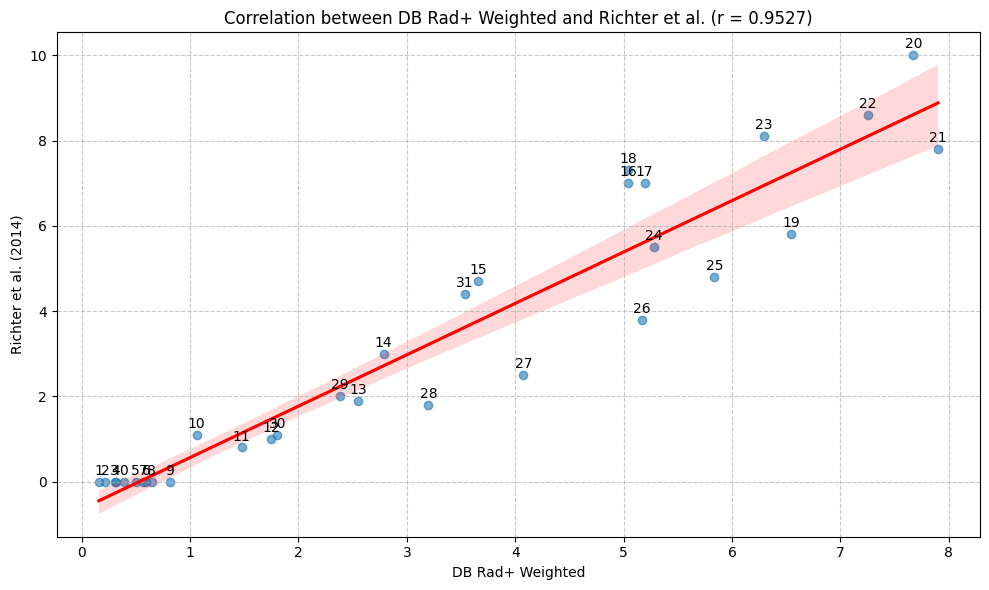

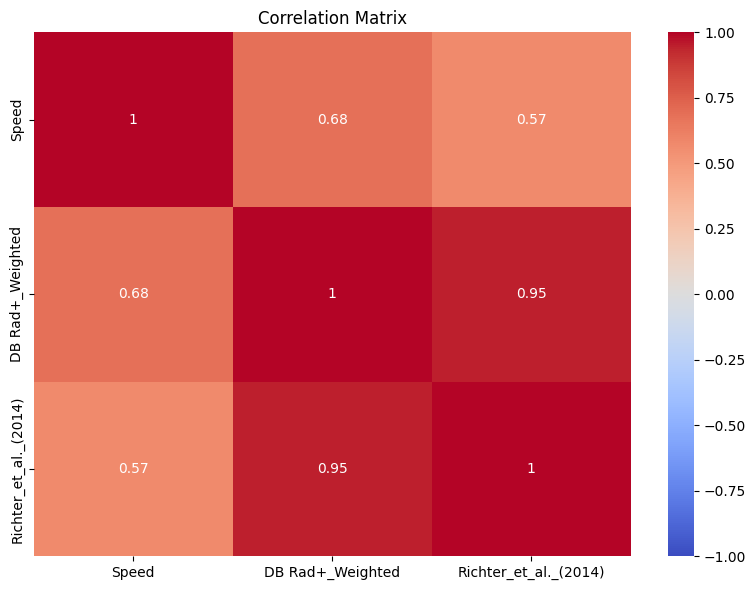

In [7]:
# Berechnung eines Pearson-Korrelationskoeffizienten und Spearman-Rangkorrelation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

# Read the CSV file
file_path = 'analysis_results/004_Richter_Geschwindigkeit/speed_distribution_data_2304-2412_RVA.csv'
df = pd.read_csv(file_path)

# Calculate Pearson correlation coefficient between DB Rad+ Weighted and Richter et al
pearson_corr, p_value = pearsonr(df['DB Rad+_Weighted'], df['Richter_et_al._(2014)'])

# Calculate Spearman rank correlation (useful for non-linear relationships)
spearman_corr, spearman_p = spearmanr(df['DB Rad+_Weighted'], df['Richter_et_al._(2014)'])

# Display the results
print(f"Pearson correlation coefficient: {pearson_corr:.4f} (p-value: {p_value:.4f})")
print(f"Spearman correlation coefficient: {spearman_corr:.4f} (p-value: {spearman_p:.4f})")

# Create a scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='DB Rad+_Weighted', y='Richter_et_al._(2014)', data=df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title(f'Correlation between DB Rad+ Weighted and Richter et al. (r = {pearson_corr:.4f})')
plt.xlabel('DB Rad+ Weighted')
plt.ylabel('Richter et al. (2014)')
plt.grid(True, linestyle='--', alpha=0.7)

# Add speeds as annotations
for i, row in df.iterrows():
    plt.annotate(f"{int(row['Speed'])}", 
                 (row['DB Rad+_Weighted'], row['Richter_et_al._(2014)']),
                 textcoords="offset points", 
                 xytext=(0,5), 
                 ha='center')

plt.tight_layout()
plt.show()

# Optional: Show correlation matrix heatmap
correlation_matrix = df[['Speed', 'DB Rad+_Weighted', 'Richter_et_al._(2014)']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()